In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from keras import Sequential

from PIL import Image
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, regularizers
from keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator



2023-03-18 22:23:34.717879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [3]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
x_train, x_test = x_train / 255., x_test / 255.

3072
3072
3072
3072
3072
3072
3072
3072


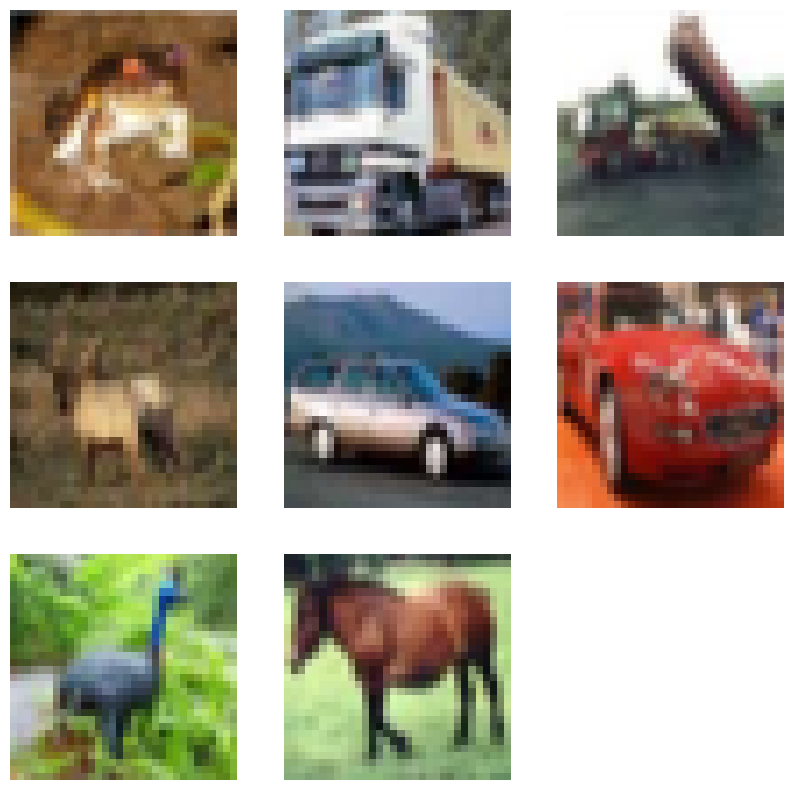

In [7]:

plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(3,3,i+1)
    img = x_train[i]
    print(img.size)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

In [10]:

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state = 42)


In [11]:

print((x_train.shape, y_train.shape))
print((x_test.shape, y_test.shape))

((24500, 32, 32, 3), (24500, 10))
((10500, 32, 32, 3), (10500, 10))


In [12]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3), classes=y_train.shape[1])

2023-03-18 22:24:49.238130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
base_model.trainable = True
set_trainable = False

for layer in base_model.layers:    
    if layer.name == "block5_conv1":        
        set_trainable = True    
    if set_trainable:        
        layer.trainable = True    
    else:        
        layer.trainable = False

In [14]:

base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [15]:
model = models.Sequential([   
    base_model,   
    layers.Flatten(),
    layers.Dense(256, activation="relu"),  
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])


model.compile(optimizer ='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:

data_add = ImageDataGenerator(featurewise_center=False, samplewise_center=False,
        featurewise_std_normalization=False, samplewise_std_normalization=False,  
        zca_whitening=False, rotation_range=0.1, 
        zoom_range =0.1, width_shift_range=0.1,
        height_shift_range=0.1, horizontal_flip=False, vertical_flip=False)  
data_add.fit(x_train)
     

In [17]:
# history = model.fit(data_add.flow
#                     (x_train, y_train, batch_size=64),
#     epochs=20, verbose=1, validation_data=(x_test, y_test))

history = model.fit(data_add.flow
                    (x_train, y_train),
                    batch_size=256,
                    epochs=30,
                    verbose=1,
                    validation_split=0.2,
                    validation_data=(x_test, y_test))



Epoch 1/30
766/766 [==============================] - 275s 358ms/step - loss: 1.6666 - accuracy: 0.3940 - val_loss: 1.1626 - val_accuracy: 0.6040
Epoch 2/30
766/766 [==============================] - 273s 356ms/step - loss: 1.2171 - accuracy: 0.5922 - val_loss: 1.0382 - val_accuracy: 0.6427
Epoch 3/30
766/766 [==============================] - 271s 354ms/step - loss: 1.0971 - accuracy: 0.6401 - val_loss: 0.9615 - val_accuracy: 0.6784
Epoch 4/30
766/766 [==============================] - 273s 357ms/step - loss: 1.0138 - accuracy: 0.6658 - val_loss: 0.9305 - val_accuracy: 0.6861
Epoch 5/30
766/766 [==============================] - 275s 359ms/step - loss: 0.9613 - accuracy: 0.6807 - val_loss: 0.9797 - val_accuracy: 0.6779
Epoch 6/30
766/766 [==============================] - 276s 360ms/step - loss: 0.9302 - accuracy: 0.6941 - val_loss: 0.9413 - val_accuracy: 0.6933
Epoch 7/30
766/766 [==============================] - 275s 359ms/step - loss: 0.8917 - accuracy: 0.7060 - val_loss: 0.9787 -

In [18]:
score = model.evaluate(x_test, y_test, verbose=0) 
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.0269598960876465 / Test accuracy: 0.7200952172279358


In [19]:
model.save("CIFAR10v3.h5")
